# I. Preparing data

In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import lib

In [118]:
import numpy as np
import os

Define directions

In [119]:
ORIGINAL_DATA_dir = 'DATASETS/ORIGINAL_DATA'
STUDIED_DATA_dir = 'DATASETS/STUDIED_DATA'

## I.1 Exploring real data

In [120]:
X_orig = np.loadtxt(os.path.join(ORIGINAL_DATA_dir, 'MLComp/MLComp.data'))

Data statistics:

In [121]:
from data_statistics import *
print "sparsity = %f"%sparsity(X_orig)
print "Number of models = %i"%num_model(X_orig)
print "Number of datasets = %i"%num_dataset(X_orig)
if sparsity(X_orig) == 0:
    print "Rank of matrix = %i"%rank(X_orig)
else:
    print "Matrix contains NaN, cannot define the rank"

sparsity = 0.932033
Number of models = 384
Number of datasets = 724
Matrix contains NaN, cannot define the rank


Load processed data.
Note: Datasets in STUDIED_DATA_dir are all the same as they are in ORIGINAL_DATA_dir, except for MLComp for which we processed to extract a dense part of the original data to reduce the sparsity.

In [122]:
X_proc = np.loadtxt(os.path.join(STUDIED_DATA_dir, 'statlog/statlog.data'))

In [123]:
print "sparsity = %f"%sparsity(X_proc)
print "Number of models = %i"%num_model(X_proc)
print "Number of datasets = %i"%num_dataset(X_proc)
if sparsity(X_proc) == 0:
    print "Rank of matrix = %i"%rank(X_proc)
else:
    print "Matrix contains NaN, cannot define the rank"

sparsity = 0.000000
Number of models = 24
Number of datasets = 22
Rank of matrix = 22


Use SVD to complete missing values:

In [124]:
from SVD_complete_missingValues import *
X_comp, _, reconstruction_err, _, _, _ = SVD_complete_missingValues(X_proc)

IndentationError: unexpected indent (SVD_complete_missingValues.py, line 107)

In [125]:
print reconstruction_err

NameError: name 'reconstruction_err' is not defined

In [126]:
print "sparsity = %f"%sparsity(X_comp)
if sparsity(X_comp) == 0:
    print "Rank of matrix = %i"%rank(X_comp)
else:
    print "Matrix contains NaN, cannot define the rank"

NameError: name 'X_comp' is not defined

## I.2 Generate random data

In [127]:
from random_data_generator import random_data
S_rank2 = random_data(10, 10, 2) # generate random matrix of rank 2
S_rank4 = random_data(10, 10, 4) # generate random matrix of rank 4
S_rank6 = random_data(10, 10, 6) # generate random matrix of rank 6
S_rank8 = random_data(10, 10, 8) # generate random matrix of rank 8

# II. APT

## II.1 APT on random data (no missing value)

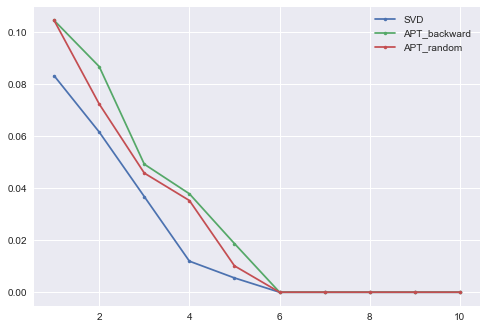

In [174]:
from numpy.linalg import matrix_rank
import math
import matplotlib.pyplot as plt
from APT_factorization import APT_recursiveElimination, APT_random, APT_GramSchmidt
RMSE_SVD = []
RMSE_APTbackward = []
RMSE_APTrandom = []
S = S_rank6
# A, idx = APT_GramSchmidt(S)
for r_ in range(1,11):
    #SVD
    u, s, vh = np.linalg.svd(S, full_matrices=False)
    s_ = list(s[:r_])+[0]*(len(s)-r_)
    smat_ = np.diag(s_)
    S_SVD = np.dot(u, np.dot(smat_, vh))
    rmse_svd = math.sqrt(((S-S_SVD)**2).sum()/S.size)
    RMSE_SVD.append(rmse_svd)
    #APT_backward
    _,_, P_backward, A_backward, _, _, T_backward = APT_recursiveElimination(S, m=r_, d=S.shape[0])
    S_APTback = np.dot(A_backward, np.dot(P_backward,T_backward))
    rmse_aptback = math.sqrt(((S-S_APTback)**2).sum()/S.size)
    RMSE_APTbackward.append(rmse_aptback)
    #APT_random
    A_random, _, T_random, _, P_random = APT_random(S, m=r_, d=S.shape[0]) 
    S_random = np.dot(A_random, np.dot(P_random,T_random))
    rmse_aptrandom = math.sqrt(((S-S_random)**2).sum()/S.size)
    RMSE_APTrandom.append(rmse_aptrandom)
    
    #APT_GS
    
plt.plot(range(1,11), RMSE_SVD, '.-', label='SVD')
plt.plot(range(1,11), RMSE_APTbackward, '.-', label='APT_backward')
plt.plot(range(1,11), RMSE_APTrandom, '.-', label='APT_random')
plt.legend()
plt.show()

## II.1 APT on random data (with missing value)

1
2
3
4
5
6
7
8
9
10


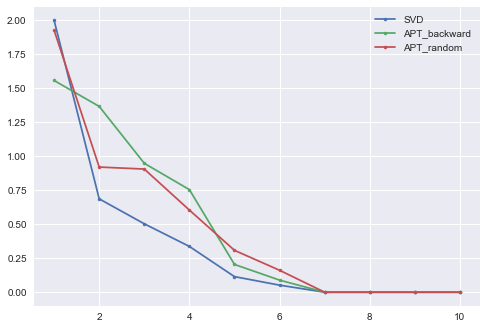

In [168]:
S = S_rank6  # 10 by 10 matrix, rank 6, ground truth
SS_miss = np.copy(S)
SS_miss[[0,0,0,0],[1,2,3,4]] = np.nan # introduce 5 missing value
missing_position = np.where(np.isnan(SS_miss))
non_missing_position = np.where(~np.isnan(SS_miss))

RMSE_SVD_miss = []
RMSE_APTbackward_miss = []
RMSE_APTrandom_miss = []
for r_ in range(1, SS_miss.shape[1]+1):
#     print r_
    median = np.nanmedian(SS_miss) # initialize with median
    SS_miss[missing_position] = median
    #SVD
    u_miss, s_miss, vh_miss = np.linalg.svd(SS_miss, full_matrices=False)
    s_miss_ = list(s_miss[:r_])+[0]*(len(s_miss)-r_) # keep only first r_ singular values
    smat_miss = np.diag(s_miss_)
    
    S_SVD_miss = np.dot(u_miss, np.dot(smat_miss, vh_miss))
#     rmse_svd_miss = math.sqrt(((S[missing_position]-S_SVD_miss[missing_position])**2).sum()/4)
    rmse_svd_miss = math.sqrt(((S[non_missing_position]-S_SVD_miss[non_missing_position])**2).sum())
    RMSE_SVD_miss.append(rmse_svd_miss)
    
    #APT_backward
    _,_, P_backward_miss, A_backward_miss, _, _, T_backward_miss = APT_recursiveElimination(SS_miss, m=r_, d=S.shape[0])
    S_APTback_miss = np.dot(A_backward_miss, np.dot(P_backward_miss,T_backward_miss))
    rmse_aptback_miss = math.sqrt(((S[non_missing_position]-S_APTback_miss[non_missing_position])**2).sum())
    RMSE_APTbackward_miss.append(rmse_aptback_miss)
    
    #APT_random
    A_random_miss, _, T_random_miss, _, P_random_miss = APT_random(SS_miss, m=r_, d=S.shape[0]) 
    S_random_miss = np.dot(A_random_miss, np.dot(P_random_miss,T_random_miss))
    rmse_aptrandom_miss = math.sqrt(((S[non_missing_position]-S_random_miss[non_missing_position])**2).sum())
    RMSE_APTrandom_miss.append(rmse_aptrandom_miss)
plt.plot(range(1,11), RMSE_SVD_miss, '.-', label='SVD')
plt.plot(range(1,11), RMSE_APTbackward_miss, '.-', label='APT_backward')
plt.plot(range(1,11), RMSE_APTrandom_miss, '.-', label='APT_random')
plt.legend()
plt.show()

In [155]:
RMSE_SVD_miss

[0.7101033558139208,
 2.1024907428441897,
 2.1027093015118994,
 2.101992150460179,
 2.1020623818045445,
 2.102064025057248,
 2.102064230757579,
 2.102064230757579,
 2.102064230757579,
 2.102064230757579]

In [135]:
len(missing_position)

2